In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install gdown
!pip install gdown

# Download the file from Google Drive
# https://drive.google.com/file/d/1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz/view?usp=sharing

# !gdown --id 1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke
!gdown --id 1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
# Extract the tar file
import tarfile

# Open the tar file
with tarfile.open('Augumented_images_new.tar', 'r') as tar:
    tar.extractall()  # Extract to the current working directory

# List the extracted files to verify
import os

# Check the contents of the current directory
print(os.listdir())


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
From (redirected): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz&confirm=t&uuid=af2ae1ac-9552-428d-ad53-989a11261d7c
To: /kaggle/working/Augumented_images_new.tar
100%|████████████████████████████████████████| 167M/167M [00:03<00:00, 44.9MB/s]
['Augumented_images_new', 'Augumented_images_new.tar', '.virtual_documents']


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/20], Train Loss: 1.5069, Train Acc: 0.4230, Val Loss: 1.1781, Val Acc: 0.5397
Epoch [2/20], Train Loss: 1.1767, Train Acc: 0.5396, Val Loss: 1.0769, Val Acc: 0.5767
Epoch [3/20], Train Loss: 1.0726, Train Acc: 0.5761, Val Loss: 0.9773, Val Acc: 0.6227
Epoch [4/20], Train Loss: 1.0125, Train Acc: 0.6028, Val Loss: 0.9717, Val Acc: 0.6290
Epoch [5/20], Train Loss: 0.9465, Train Acc: 0.6357, Val Loss: 0.8641, Val Acc: 0.6555
Epoch [6/20], Train Loss: 0.9191, Train Acc: 0.6452, Val Loss: 0.9407, Val Acc: 0.6513
Epoch [7/20], Train Loss: 0.9026, Train Acc: 0.6490, Val Loss: 0.8428, Val Acc: 0.6764
Epoch [8/20], Train Loss: 0.8722, Train Acc: 0.6594, Val Loss: 0.8226, Val Acc: 0.6757
Epoch [9/20], Train Loss: 0.8207, Train Acc: 0.6784, Val Loss: 0.8348, Val Acc: 0.6827
Epoch [10/20], Train Loss: 0.8205, Train Acc: 0.6813, Val Loss: 0.7734, Val Acc: 0.6980
Epoch [11/20], Train Loss: 0.7973, Train Acc: 0.6866, Val Loss: 0.7885, Val Acc: 0.6792
Epoch [12/20], Train Loss: 0.7745, Train 

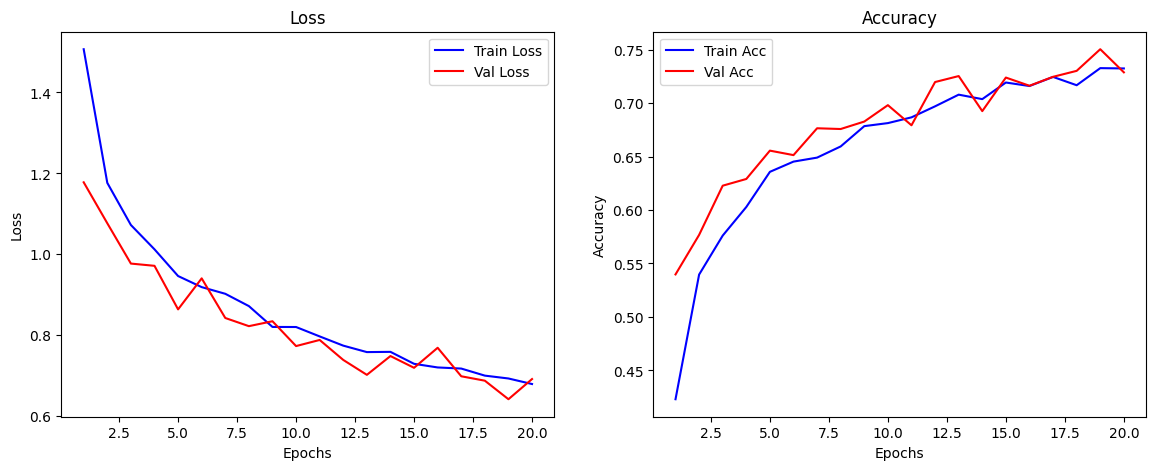

Test Accuracy: 0.7204


In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Hair removal function
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Black hat filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)

    # Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)

    # Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)

    # Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    return img, dst

# Custom dataset with preprocessing
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.classes = os.listdir(image_dir)  # Assuming subfolder names are class names
        self.filepaths = []
        self.labels = []
        self.transform = transform

        for idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(image_dir, class_name)
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                self.filepaths.append(image_path)
                self.labels.append(idx)  # Class index as label

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image_path = self.filepaths[idx]
        img, hair_removed_img = apply_dullrazor(image_path)

        # Convert to tensor
        if self.transform:
            img = self.transform(hair_removed_img)

        label = self.labels[idx]
        return img, label

# Data augmentation without changing color
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
image_dir = '/kaggle/working/Augumented_images_new'
dataset = SkinCancerDataset(image_dir, transform=data_transforms)

# Train, validation, test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# VGG19 model with dropout and regularization
class VGG19Modified(nn.Module):
    def __init__(self, num_classes):
        super(VGG19Modified, self).__init__()
        self.vgg = models.vgg19(pretrained=True)
        
        # Freeze feature extraction layers
        for param in self.vgg.features.parameters():
            param.requires_grad = False
        
        # Modify the classifier
        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.vgg(x)
        return x

# Instantiate model, loss function, and optimizer
num_classes = len(os.listdir(image_dir))  # Assuming folder names are class labels
model = VGG19Modified(num_classes=num_classes)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)  # Added weight_decay for L2 regularization

# Training and validation function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_loss, train_acc, val_loss, val_acc

# Training the model
num_epochs = 20
train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# Plot accuracy and loss
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Train Acc')
    plt.plot(epochs, val_acc, 'r', label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_loss, val_loss, train_acc, val_acc)

# Testing the model
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')


In [4]:
# Save the model's state_dict (weights only)
torch.save(model.state_dict(), "skin_cancer_classification_VGG19_20epoch_FT.pth")